# Most Used Tacticts in the Top 5 European’s League (2/2)

#### We go further in the analysis to assess which tactics perform the best.

Metrics : 
- Goals Scored Per Game: Average goals scored per match with a formation.
- Goals Conceded Per Game: Average goals conceded per match with a formation.
- Point Per Game: Average goals conceded per match with a formation.

### Load the Dataset

In [9]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_games = pd.read_csv('./Dataset/games.csv')
df_club = pd.read_csv('./Dataset/clubs.csv')

### Filtering Data

To kick things off, we need to reorganize the `df_games` dataframe, which contains the results and details of every match since 2012.

Our analysis focuses on the **2023-2024 season** and Europe’s **Big Five Leagues**. The first step is to filter our dataset accordingly.

In [10]:
list_big_five_championship = ['FR1', 'ES1', 'IT1', 'GB1', 'L1'] #Code Id Big Five Leagues

start_season = '2023-08-01'
end_season = '2024-07-01'

df_games["date"] = pd.to_datetime(df_games["date"])
df_games_big_five = df_games[df_games['competition_id'].isin(list_big_five_championship)]
df_games_big_five = df_games_big_five[(df_games_big_five["date"]>=start_season) &
                                      (df_games_big_five["date"]<=end_season)]

Next, we’ll continue working on our dataframe. For our analysis, we only need  four columns: “home_club_formation” , “away_club_formation”, "Home_club_goals" and "away_club_goals". \
Additionally, we will standardize the formations by ignoring specific variations, such as treating a 4-3-3 Attacking the same as a standard 4-3-3, or a 3-5-2 Flat the same as a basic 3-5-2.

In [11]:
df_tactics = df_games_big_five[["home_club_formation","away_club_formation","home_club_goals","away_club_goals"]] 
df_tactics = pd.concat([
    df_tactics[["home_club_formation", "home_club_goals","away_club_goals"]].rename(
        columns={"home_club_formation": "formation", "home_club_goals": "goals scored","away_club_goals":"goals conceded"}
    ),
    df_tactics[["away_club_formation", "away_club_goals", "home_club_goals"]].rename(
        columns={"away_club_formation": "formation", "away_club_goals": "goals scored","home_club_goals": "goals conceded"}
    )
], axis=0).reset_index(drop=True)

df_tactics["formation"] = df_tactics["formation"].str.split().str[0]

For each match, 3 points are awarded to the team composition that scored the most goals, 0 points to the losing composition, and 1 point for a draw.

In [12]:
def  point(x):
    p = 0 
    if x["goals scored"]==x["goals conceded"]:
        p = 1
    elif x["goals scored"]>x["goals conceded"]:
        p = 3
    else :
        p = 0
    return p


df_tactics["point"] = df_tactics.apply(point, axis =1)

In [15]:
df_tactics.head(10)

,formation,goals scored,goals conceded,point
0,3-4-3,0.0,1.0,0
1,4-3-3,1.0,2.0,0
2,4-2-3-1,5.0,1.0,3
3,4-2-3-1,3.0,1.0,3
4,4-3-3,3.0,1.0,3
5,3-4-2-1,0.0,1.0,0
6,4-2-3-1,0.0,0.0,1
7,4-2-3-1,0.0,1.0,0
8,4-2-3-1,2.0,0.0,3
9,3-4-2-1,3.0,2.0,3


Now we can calculate the differents metrics four our analysis: 
- Goals Scored Per Game: Average goals scored per match with a formation.
- Goals Conceded Per Game: Average goals conceded per match with a formation.
- Point Per Game: Average goals conceded per match with a formation.

We only keep tactics that have been used at least 5% of the time.

In [17]:
n_match = len(df_tactics)
df_tactics = df_tactics[df_tactics["formation"].map(df_tactics["formation"].value_counts() / n_match)>0.05]

df_tactics_stat = (df_tactics
                   .groupby("formation")
                   .agg(
                       {
                           "goals scored": "mean",
                           "goals conceded": "mean", 
                           "point": "mean"
                        }
                   )
                   )

df_tactics_rank_goals_scored = df_tactics_stat.sort_values(by="goals scored",ascending = False)
df_tactics_rank_goals_scored["ratio scored/conceded"] = df_tactics_rank_goals_scored["goals scored"]/df_tactics_rank_goals_scored["goals conceded"]
df_tactics_rank_goals_scored.rename(columns={"goals scored" :"average goals scored","goals conceded":"average goals conceded"},inplace=True)
df_tactics_stat

,goals scored,goals conceded,point
formation,,,
3-4-2-1,1.364322,1.487437,1.266332
3-4-3,1.403409,1.420455,1.386364
3-5-2,1.382979,1.428191,1.348404
4-2-3-1,1.493671,1.479065,1.393379
4-3-3,1.582242,1.321689,1.529840
4-4-2,1.482940,1.446194,1.356955


### Vizualisation

C:\Users\Florian\AppData\Local\Temp\ipykernel_31284\1964261916.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='formation',


Text(0, 0.5, 'Average Points')

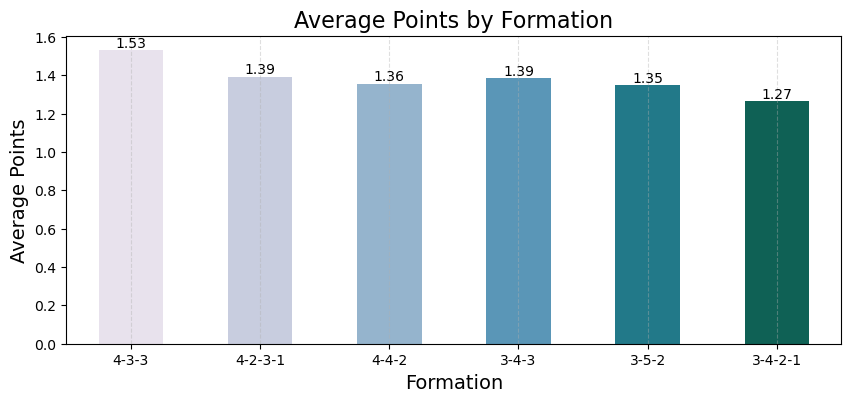

In [28]:
plt.figure(figsize=(10, 4))
palette = sns.color_palette("PuBuGn", len(df_tactics_rank_goals_scored))
bar_plot = sns.barplot(x='formation', 
                       y='point', 
                       data=df_tactics_rank_goals_scored, 
                       palette=palette,
                       width=0.5)

for i in bar_plot.containers:
    bar_plot.bar_label(i, fmt='%.2f', label_type='edge', fontsize=10)

plt.title('Average Points by Formation', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.4)  
plt.xlabel('Formation', fontsize=14)
plt.ylabel('Average Points', fontsize=14)

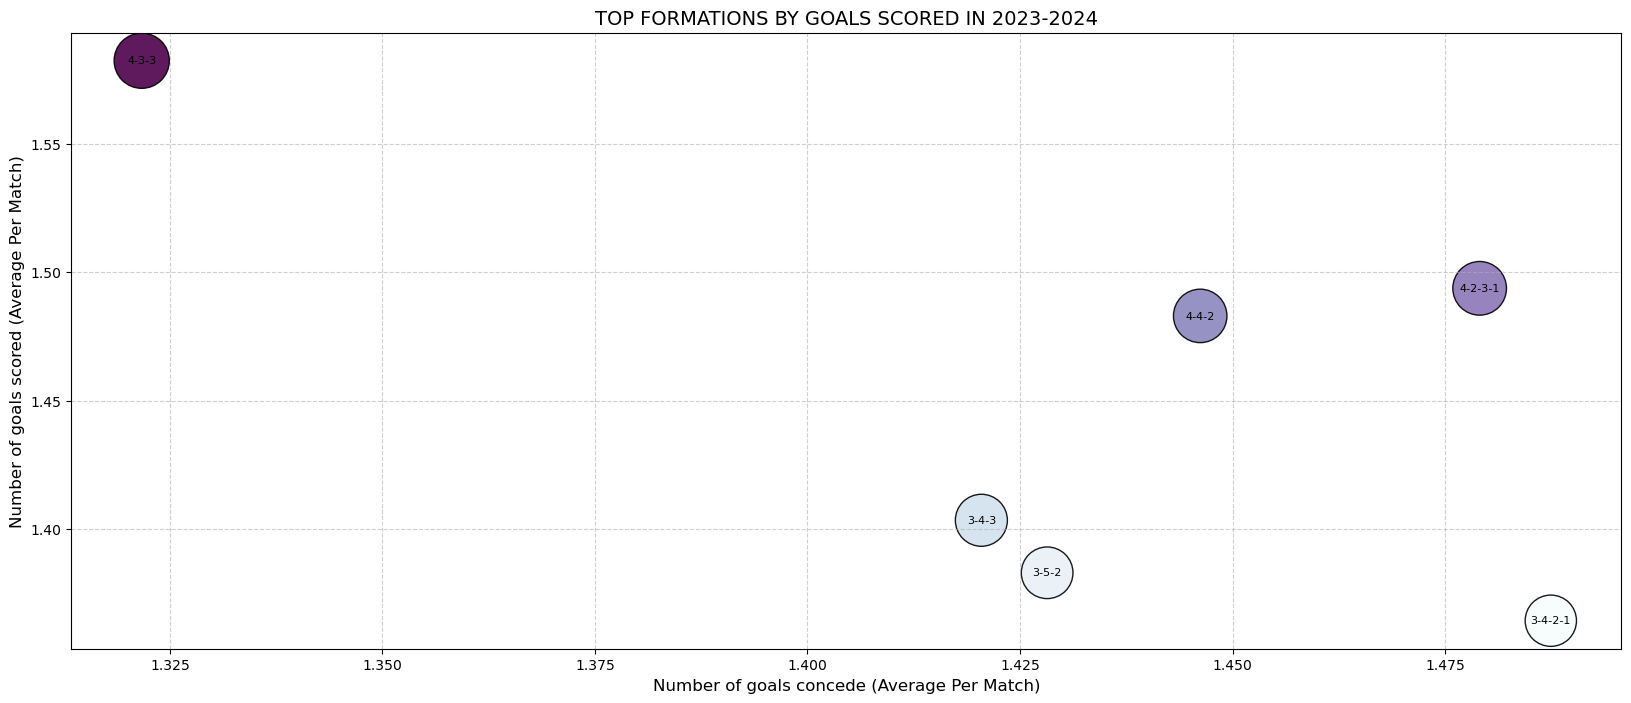

In [19]:
df_ranking_top = df_tactics_rank_goals_scored.sort_values(by="average goals scored",ascending=False)

 
bubble_sizes = (df_ranking_top['average goals scored'])*1000

plt.figure(figsize=(20,8))
plt.scatter(
    df_ranking_top['average goals conceded'],                  
    df_ranking_top['average goals scored'],           
    s=bubble_sizes,               
    alpha=0.9,                     
    edgecolors="black",                 
    c=df_ranking_top['average goals scored'],              
    cmap="BuPu"               
)


for i, team in enumerate(df_ranking_top.index):
    plt.text(
        df_ranking_top['average goals conceded'].iloc[i],df_ranking_top['average goals scored'].iloc[i], 
        team, fontsize=8, ha='center', va='center')

plt.title("TOP FORMATIONS BY GOALS SCORED IN 2023-2024", fontsize=14)
plt.ylabel("Number of goals scored (Average Per Match)", fontsize=12)
plt.xlabel("Number of goals concede (Average Per Match)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
